In [1]:
# Libraries
library(tidyverse) # ggplot(.)
library(mgcv) # gam(.)
library(splines) # bs(.) (B-splines)
library(MuMIn) # dredge(.)
library(fields) # quilt.plot(.)
library(lawstat) # runs.test(.)
# Read dataset
df <- read.csv("HornsRev.csv")
# Set Impact as factor
df$Impact <- as.factor(df$Impact)

── Attaching packages ──────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘tidyr’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
Warning message:
“package ‘dplyr’ was built under R version 4.1.1”
Warning message:
“package ‘stringr’ was built under R version 4.1.1”
Warning message:
“package ‘forcats’ was built under R version 4.1.1”
── Conflicts ─────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: nlme


Attaching package: ‘nlme’


The following object is mas

Fit a quasi-Poisson penalised spline based GAM (mgcv::gam(.)) as follows. Print out a summary of the model and inspect the results.

In [2]:
PRS <- mgcv::gam(Nhat ~ s(XPos) + s(YPos) + s(Depth) + Impact,
data=df, family=quasipoisson, offset=log(Area))
summary(PRS)


Family: quasipoisson 
Link function: log 

Formula:
Nhat ~ s(XPos) + s(YPos) + s(Depth) + Impact

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6743     0.3273   8.171 3.19e-16 ***
Impact1       0.2547     0.0316   8.059 7.99e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df      F p-value    
s(XPos)  8.975  9.000  89.29  <2e-16 ***
s(YPos)  8.981  9.000  84.59  <2e-16 ***
s(Depth) 8.072  8.315 105.26  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0347   Deviance explained = 19.2%
GCV = 250.16  Scale est. = 393.45    n = 27854

2. View the partial plots when the:
a. 𝑦-axes are all on the same scale.

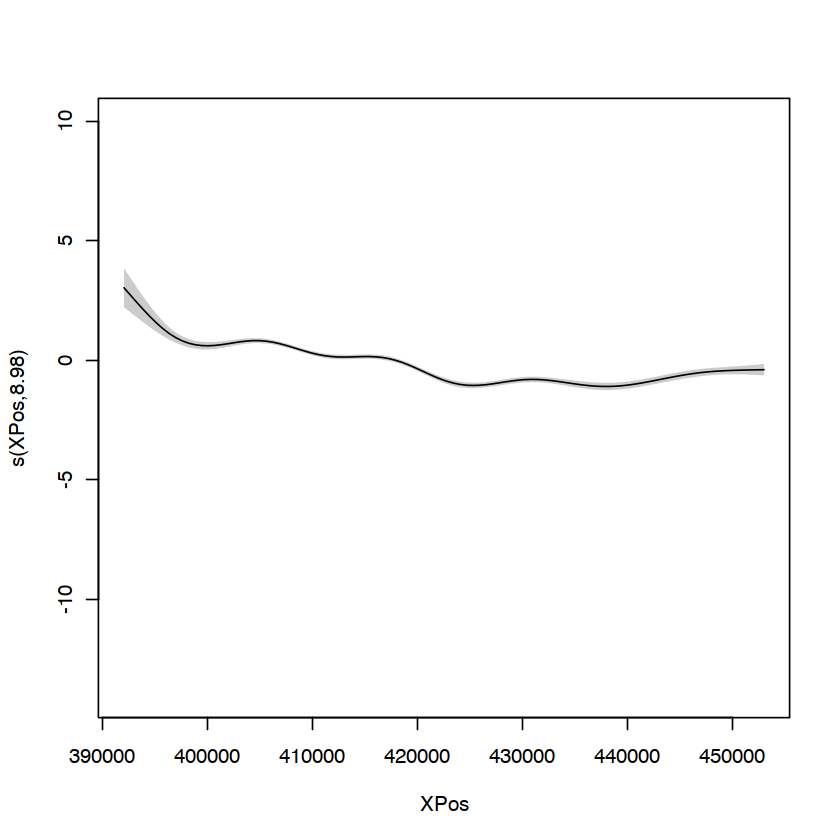

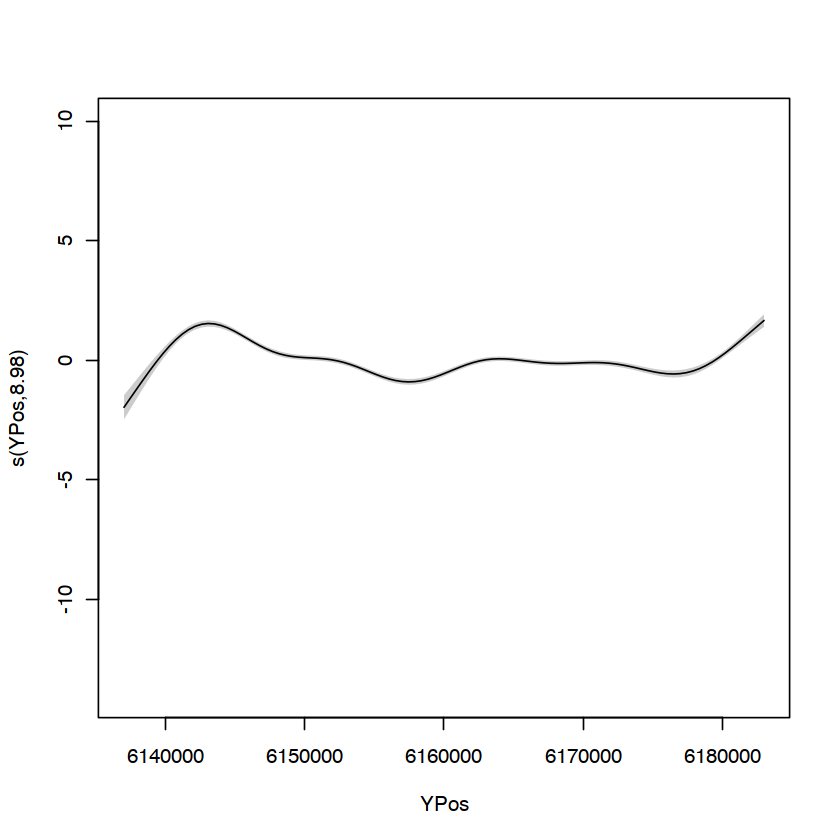

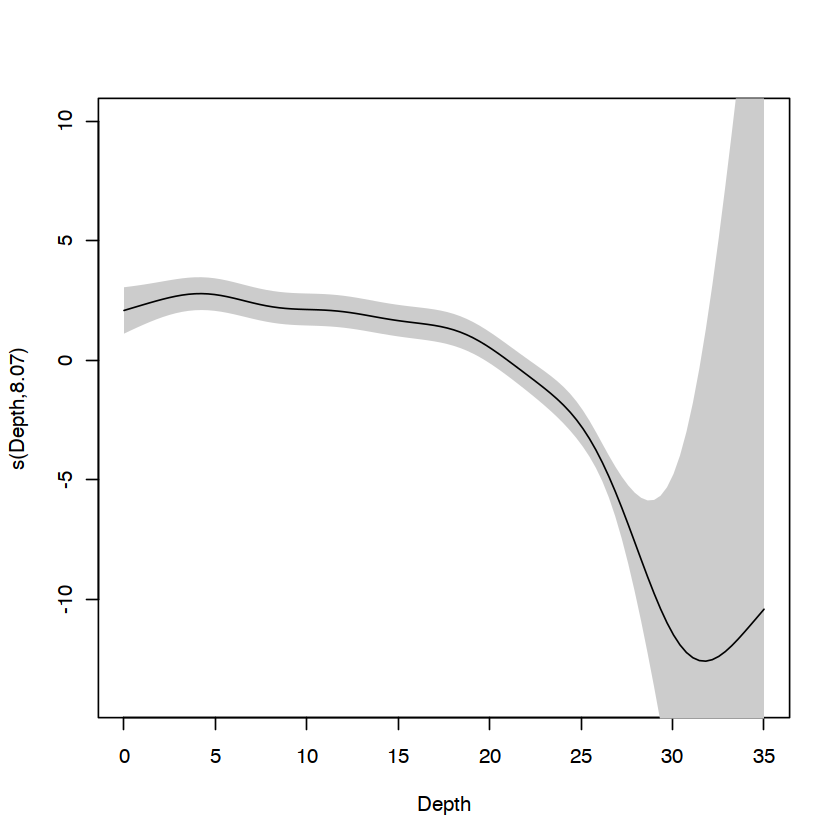

In [14]:
plot(PRS, shade = T, residuals = F, ylim=c(-14,10))


3. Visually compare the Depth relationship obtained using the PRS model to a model that uses a B-spline basis function instead with just one knot at 20m:


Family: quasipoisson 
Link function: log 

Formula:
Nhat ~ s(XPos) + s(YPos) + Impact + splines::bs(Depth, knots = 20)

Parametric coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       6.3269     0.1102  57.420   <2e-16 ***
Impact1                           0.2539     0.0159  15.970   <2e-16 ***
splines::bs(Depth, knots = 20)1  -2.1888     0.1970 -11.110   <2e-16 ***
splines::bs(Depth, knots = 20)2   0.3245     0.1451   2.236   0.0253 *  
splines::bs(Depth, knots = 20)3  -8.8092     0.3168 -27.806   <2e-16 ***
splines::bs(Depth, knots = 20)4 -37.8328     3.5819 -10.562   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
          edf Ref.df     F p-value    
s(XPos) 8.963  8.999 355.1  <2e-16 ***
s(YPos) 8.983  9.000 337.3  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0341   Deviance explained = 19.1

Warning message in stats::termplot(PRS_B, se = T):
“'model' appears to involve interactions: see the help page”


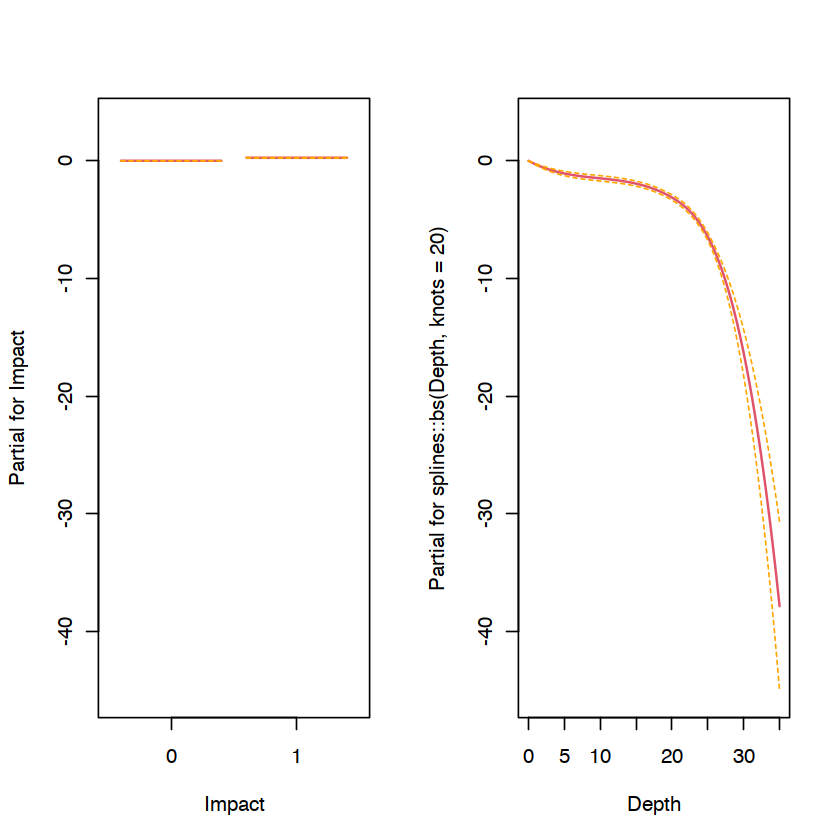

In [11]:
par(mfrow=c(1,2))
# Replace s(Depth) with bs(Depth, knots=20) in the model
PRS_B <- stats::update(PRS, .~. -s(Depth) + splines::bs(Depth, knots=20))
summary(PRS_B)
stats::termplot(PRS_B, se=T)

4. Carry out model selection on the terms in the working GAM (i.e. the PRS model fitted in 1.) using the dredge function in the MuMIn library. Use QAIC to rank the different models. See lecture notes Section 5.5 for a reminder of how to use the dredge function (the overdispersion parameter estimate can be found in PRS$scale).

In [31]:
options(na.action="na.fail") # fail-safe
PRS_pois = update(PRS, family = "poisson")
models = dredge(PRS_pois, rank = "QAIC", chat = PRS$scale)
head(models)

Fixed term is "(Intercept)"

Warning message in gam.fit3(x = args$X, y = args$y, sp = lsp, Eb = args$Eb, UrS = args$UrS, :
“Algorithm did not converge”


,(Intercept),Impact,s(Depth),s(XPos),s(YPos),df,logLik,QAIC,delta,weight
,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
16,2.696168,+,+,+,+,28,-3494764,17824.42,0.00000,1.000000e+00
15,2.838021,NA,+,+,+,27,-3507645,17887.85,63.42704,1.686527e-14
8,2.812670,+,+,+,NA,19,-3651125,18601.24,776.81722,2.071494e-169
7,2.977312,NA,+,+,NA,18,-3668453,18687.28,862.86075,4.287152e-188
12,2.896827,+,+,NA,+,19,-3675046,18722.78,898.36499,8.366063e-196
11,3.083521,NA,+,NA,+,18,-3698044,18837.68,1013.25703,9.419599e-221


5. Download HornsRevPredictionData.csv from Moodle. This file contains a fine grid of XPos/YPos values and corresponding Depth measurements. Use the “best” model identified in 4. to predict over this fine grid and produce a spatial plot of all the results (pre/post-impact both on the link and response scale).

In [27]:
predData = read.csv("HornsRevPredictionData.csv")
# Predict on the link scale
NhatPredLink = predict(PRS, newdata=predData, se=T, type="link")
# Predict on the response scale
NhatPredRes = predict(PRS, newdata=predData, se=T, type="response")

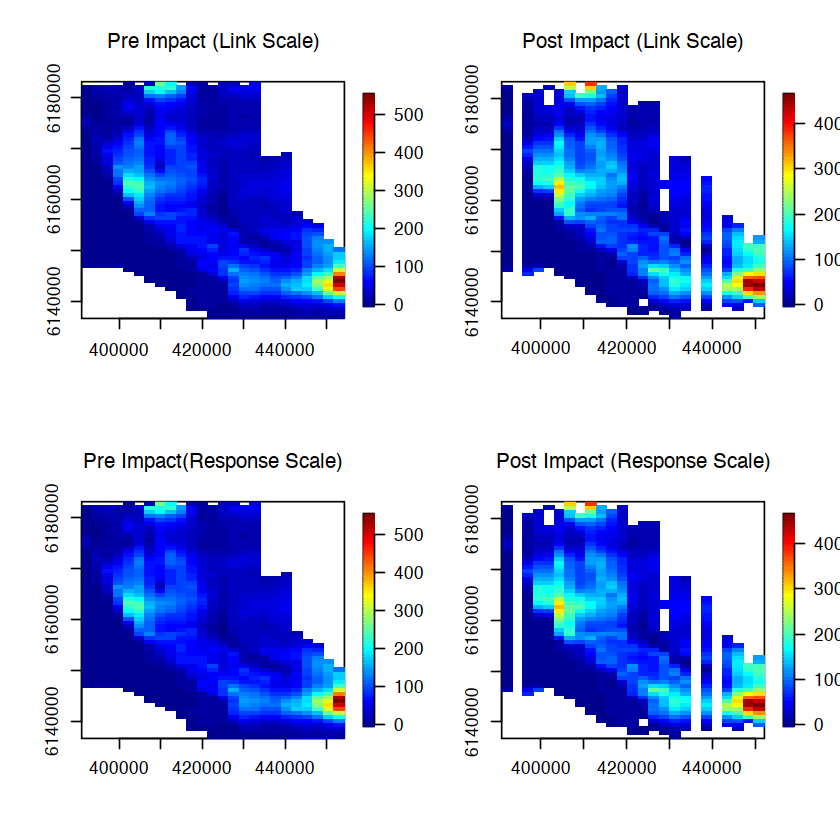

In [52]:
par(mfrow=c(2,2))
# Loop across all phases
for(phase in c(0,1)){
  fields::quilt.plot(df$XPos[which(df$Impact == phase)], 
                       df$YPos[which(df$Impact == phase)],
                       fitted(PRS)[which(df$Impact == phase)],
                       nrow=25, ncol=60,
                       #zlim=range(NhatPredLink$fit),
                       main=paste(ifelse(phase == 0, "Pre Impact (Link Scale)", "Post Impact (Link Scale)")))
}
for(phase in c(0,1)){
  iteration = df$Impact %in% phase
  fields::quilt.plot(df$XPos[which(df$Impact == phase)], 
                       df$YPos[which(df$Impact == phase)],
                       fitted(PRS)[which(df$Impact == phase)],
                       nrow=25, ncol=60,
                       # zlim=range(NhatPredRes$fit),
                       main=paste(ifelse(phase == 0, "Pre Impact(Response Scale)", "Post Impact (Response Scale)")))
}

6. Fit a GAM with an interaction between Impact and XPos.

In [45]:
PRS_Int <- mgcv::gam(Nhat ~ s(XPos, by=Impact) + s(YPos) +
    s(Depth) + Impact,
    data=df, family=quasipoisson, offset=log(Area)
)
summary(PRS_Int)


Family: quasipoisson 
Link function: log 

Formula:
Nhat ~ s(XPos, by = Impact) + s(YPos) + s(Depth) + Impact

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -4.1859     0.2051  -20.41   <2e-16 ***
Impact1       7.0887     0.1914   37.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df    F p-value    
s(XPos):Impact0 8.985  9.000 2585  <2e-16 ***
s(XPos):Impact1 8.986  9.000 2530  <2e-16 ***
s(YPos)         8.983  9.000 2165  <2e-16 ***
s(Depth)        8.109  8.357 2597  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0554   Deviance explained = 24.9%
GCV = 232.67  Scale est. = 15.02     n = 27854

7. Use the model with the interaction term (identified in 6.) to predict over the fine grid (HornsRevPredictionData.csv) and produce a spatial plot of all the results (pre/post-impact both on the link and response scale).

In [46]:
NhatPredLink_2 = predict(PRS_Int, newdata=predData, se=T, type="link")
# Predict on the response scale
NhatPredRes_2 = predict(PRS_Int, newdata=predData, se=T, type="response")

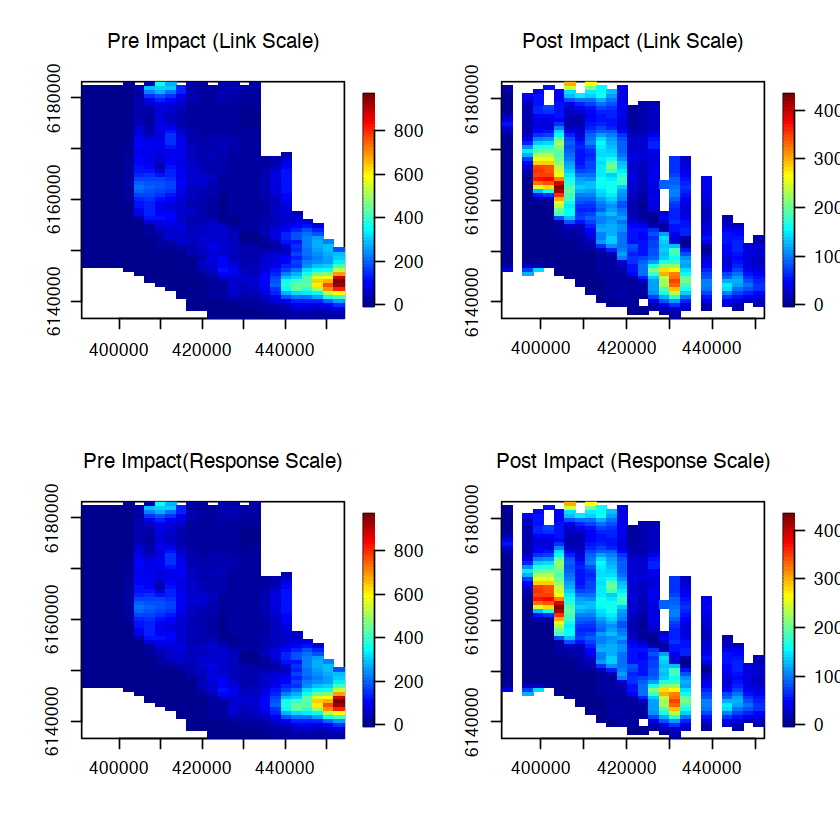

In [50]:
par(mfrow=c(2,2))
# Loop across all phases
for(phase in c(0,1)){
  fields::quilt.plot(df$XPos[which(df$Impact == phase)], 
                       df$YPos[which(df$Impact == phase)],
                       fitted(PRS_Int)[which(df$Impact == phase)],
                       nrow=25, ncol=60,
                       #zlim=range(NhatPredLink$fit),
                       main=paste(ifelse(phase == 0, "Pre Impact (Link Scale)", "Post Impact (Link Scale)")))
}
for(phase in c(0,1)){
  iteration = df$Impact %in% phase
  fields::quilt.plot(df$XPos[which(df$Impact == phase)], 
                       df$YPos[which(df$Impact == phase)],
                       fitted(PRS_Int)[which(df$Impact == phase)],
                       nrow=25, ncol=60,
                       # zlim=range(NhatPredRes$fit),
                       main=paste(ifelse(phase == 0, "Pre Impact(Response Scale)", "Post Impact (Response Scale)")))
}


8. Carry out a runs test on the Pearsons residuals for this interaction based model.


	Runs Test - Two sided

data:  residuals(PRS_Int, type = "pearson")
Standardized Runs Statistic = -122.92, p-value < 2.2e-16


[1] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
  [6] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [11] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [16] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [21] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [26] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [31] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [36] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [41] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [46] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [51] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [56] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [61] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [66] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [71] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [76] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [81] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [86] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [91] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08
 [96] -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08 -1.490116e-08

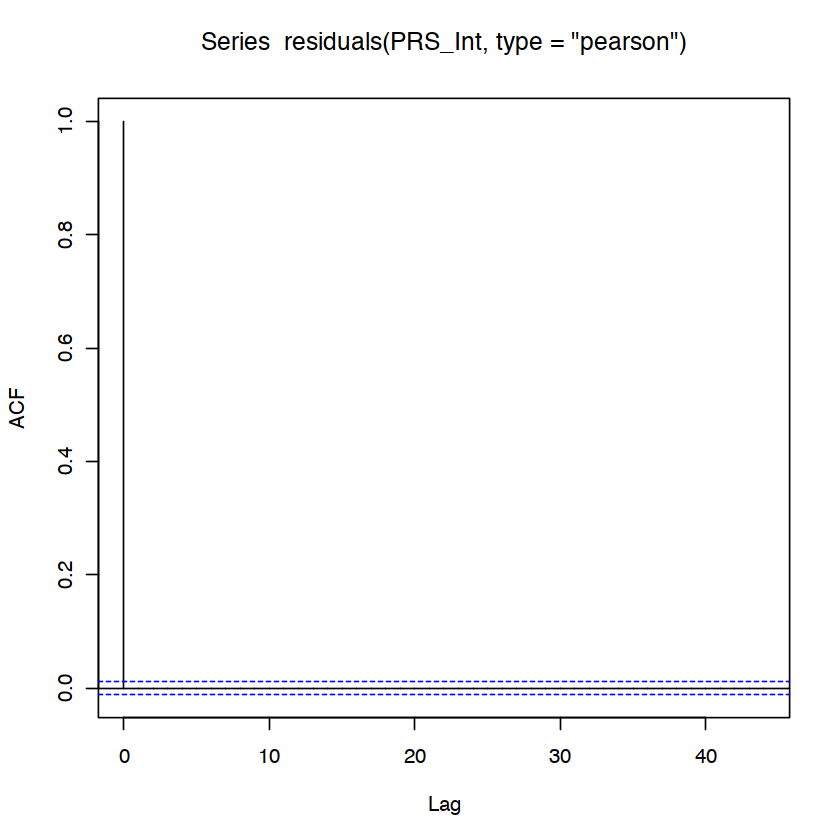

In [51]:
runs.test(residuals(PRS_Int, type = 'pearson'))
residuals(PRS_Int, type = 'pearson')[1:100]
acf(residuals(PRS_Int, type = 'pearson'))